In [90]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [39]:
import os
def read_dataset(folder_path):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            data_dict[filename] = df.astype(float)
    return data_dict

# Example usage:
# folder_data = read_all_csv_in_folder("../Reference")

In [91]:
ds = {}
dsLists = ["AICU","Automatoes","Digilog","IUACAAS","Reference","TheAutomators"]
for name in dsLists:
    folder_path = f"../{name}"
    data_dict = read_dataset(folder_path)
    ds[name] = data_dict

In [92]:
def reshape_data(df, sample_per_day):
    total_samples = len(df)
    num_days = total_samples // sample_per_day 

    reshaped_data = []

    for i in range(num_days):
        start = i * sample_per_day
        end = start + sample_per_day
        window = df.iloc[start:end]
        feature_vector = window.mean().values  
        reshaped_data.append(feature_vector)

    return pd.DataFrame(reshaped_data, columns=df.columns)

In [93]:
from scipy.stats import pearsonr
def compute_correlation_matrix(df_X: pd.DataFrame, df_Y: pd.DataFrame) -> pd.DataFrame:
    corr_matrix = pd.DataFrame(index=df_X.columns, columns=df_Y.columns)
    for x_col in df_X.columns:
        for y_col in df_Y.columns:
            corr, _ = pearsonr(df_X[x_col], df_Y[y_col])
            corr_matrix.loc[x_col, y_col] = corr
    return corr_matrix.astype(float)


In [94]:
def compute_correlation_dict():
    corr_dict = {}
    for greenhouse in ds:
        for table in ds[greenhouse]:
            if(table == "GreenhouseClimate.csv"):
                print(f"Processing {greenhouse} - {table}")
                features = reshape_data(ds[greenhouse][table],288)
                corr = compute_correlation_matrix(features, ds[greenhouse]["Resources.csv"])
                corr_dict[greenhouse] = corr
    return corr_dict

Processing AICU - GreenhouseClimate.csv
Processing Automatoes - GreenhouseClimate.csv
Processing Digilog - GreenhouseClimate.csv
Processing IUACAAS - GreenhouseClimate.csv
Processing Reference - GreenhouseClimate.csv
Processing TheAutomators - GreenhouseClimate.csv


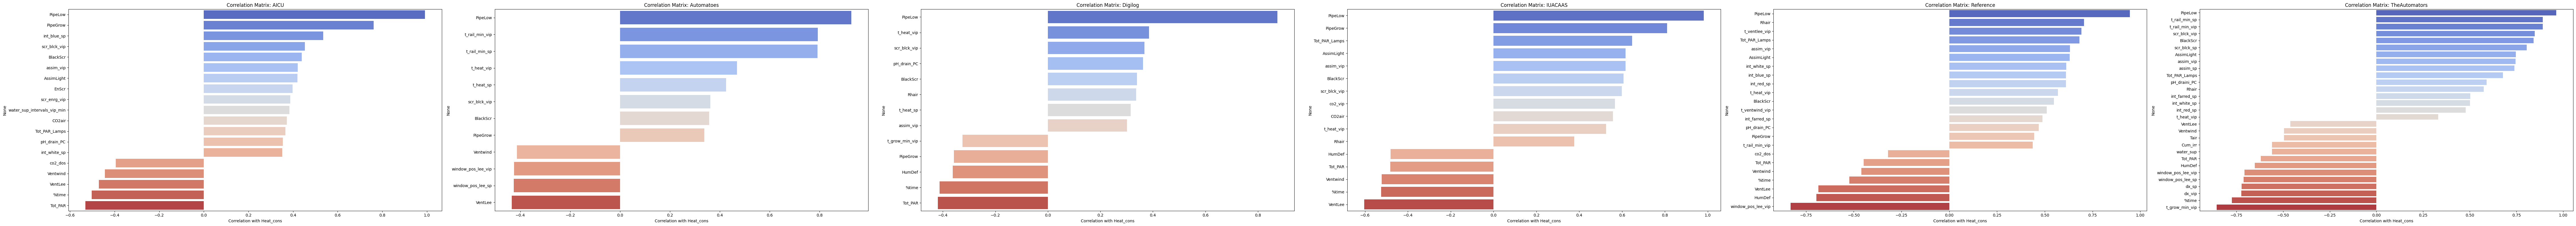

In [96]:
def plot_correlation_dict(corr_dict, figsize=(90, 8)):
    n = len(corr_dict)
    fig, axes = plt.subplots(1, n, figsize=figsize, squeeze=False)
    for idx, (key, corr_df) in enumerate(corr_dict.items()):
        # Select absolute correlations >= 0.4 with Heat_cons, drop NaNs, sort descending
        corr_heat_cons = corr_df["Heat_cons"].dropna()
        filtered = corr_heat_cons[abs(corr_heat_cons) >= 0.3].sort_values(ascending=False)
        sns.barplot(x=filtered.values, y=filtered.index, orient='h', palette='coolwarm', ax=axes[0, idx])
        axes[0, idx].set_xlabel('Correlation with Heat_cons')
        axes[0, idx].set_title(f'Correlation Matrix: {key}')
    plt.tight_layout()
    return fig, axes

# Example usage:
corr_dict = compute_correlation_dict()
fig, axes = plot_correlation_dict(corr_dict)

## Model Selection

### LSTM

In [98]:
import torch
import torch.nn as nn


In [99]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True  # Input shape: (batch, seq_len, input_size)
        )
        
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Khởi tạo hidden state và cell state ban đầu
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass qua LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))  # out shape: (batch, seq_len, hidden_size)
        
        # Lấy output ở bước cuối cùng
        out = self.fc(out[:, -1, :])  # shape: (batch, output_size)
        
        return out

In [ ]:
sample_per_day = 288 # 5 phút 

features = ["BlackScr","PipeGrow","PipeLow","Tot_PAR","VentLee","Ventwind","t_heat_sp",""]
climate = ds["AICU"]["GreenhouseClimate.csv"]
resource = ds["AICU"]["Resources.csv"]

N_days = len(climate) // sample_per_day

# Reshape input: [samples, timesteps, features]
X_seq = []
for i in range(N_days):
    start = i * sample_per_day
    end = start + sample_per_day
    X_seq.append(climate.iloc[start:end].values)

X_seq = np.array(X_seq)  # Shape: (166, 288, N_weather)
y = resource["Heat_cons"].values.reshape(-1,1)   # Shape: (166, N_resource)

# Standarize
scaler_X = StandardScaler()
X_seq_scaled = np.array([scaler_X.fit_transform(day) for day in X_seq])
X_seq_scaled = np.nan_to_num(X_seq_scaled)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)
y_scaled = np.nan_to_num(y_scaled)
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_scaled, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")